In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
import os
import pandas as pd
import anndata as ad
import seaborn as sns
import numpy as np
from statsmodels.nonparametric.kernel_density import KDEMultivariateConditional,EstimatorSettings

In [2]:
sc.set_figure_params(figsize=(4,4),  dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
os.getcwd()

'/mnt/f/M-cells/code/Fezf2_thymus'

In [4]:
adata = sc.read("/mnt/e/Archive/Joe/processed_data/M_cell/h5ad_files/combined_WT_fezf2_KO_all_genes.h5ad")

# UMAPs

In [7]:
adata.obs.genotype.value_counts()

Fezf2_KO    5550
WT          5443
Name: genotype, dtype: int64

# Abundance of clusters WT vs KO

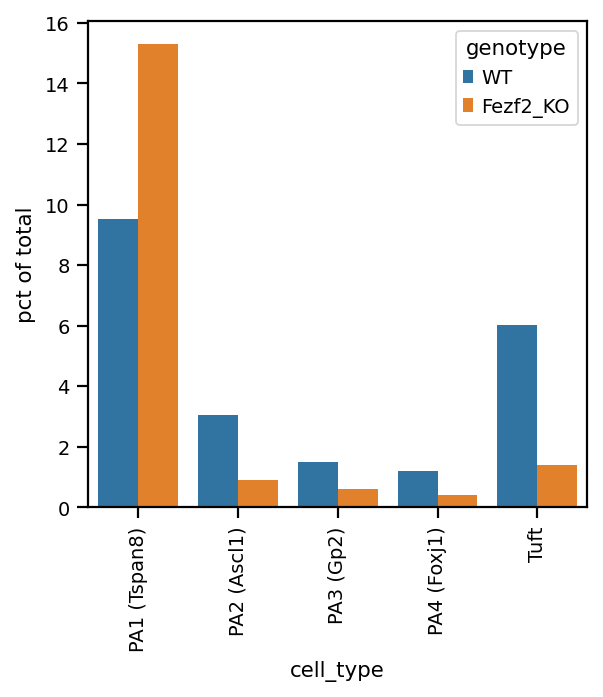

In [10]:
koData = adata[(adata.obs.genotype == "Fezf2_KO")]
wtData = adata[(adata.obs.genotype == "WT")]
abundances = pd.DataFrame()
for cellType in adata.obs.cell_type.unique():
    fracKO = len(koData[koData.obs.cell_type == cellType])/len(koData)*100
    fracWT = len(wtData[wtData.obs.cell_type == cellType])/len(wtData)*100
    data=pd.DataFrame([[fracWT, "WT", cellType], [fracKO, "Fezf2_KO", cellType]], columns=["pct of total", "genotype", "cell_type"])
    abundances = pd.concat([abundances, data])
abundances = abundances[abundances.cell_type.isin(["PA1 (Tspan8)", "PA2 (Ascl1)", "PA3 (Gp2)", "PA4 (Foxj1)", "Tuft"])].copy()
abundances.cell_type = abundances.cell_type.astype("category")
abundances.cell_type.cat.remove_unused_categories()
abundances.cell_type.cat.reorder_categories(["PA1 (Tspan8)", "PA2 (Ascl1)", "PA3 (Gp2)", "PA4 (Foxj1)", "Tuft"], inplace=True)
sns.barplot(
    data=abundances,
    x="cell_type",
    y="pct of total",
    hue="genotype",
)
plt.xticks(rotation = 90)
plt.savefig("/mnt/f/M-cells/analysis/Paper figs/Fig 3 (Fezf2 KO)/3C_susbet_differential_abundance.pdf", dpi=300, bbox_inches="tight")
plt.show()

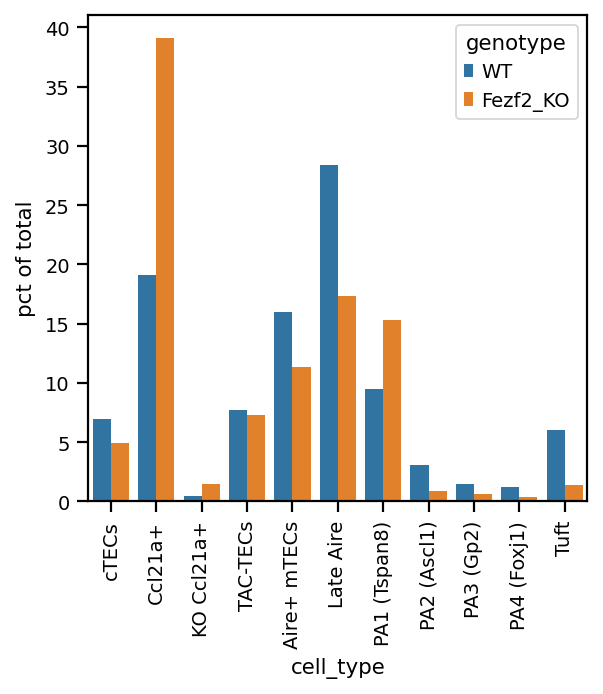

In [11]:
koData = adata[(adata.obs.genotype == "Fezf2_KO")]
wtData = adata[(adata.obs.genotype == "WT")]
abundances = pd.DataFrame()
for cellType in adata.obs.cell_type.unique():
    fracKO = len(koData[koData.obs.cell_type == cellType])/len(koData)*100
    fracWT = len(wtData[wtData.obs.cell_type == cellType])/len(wtData)*100
    data=pd.DataFrame([[fracWT, "WT", cellType], [fracKO, "Fezf2_KO", cellType]], columns=["pct of total", "genotype", "cell_type"])
    abundances = pd.concat([abundances, data])
abundances.cell_type = abundances.cell_type.astype("category")
abundances.cell_type.cat.reorder_categories(["cTECs", 'Ccl21a+', "KO Ccl21a+", 'TAC-TECs', 'Aire+ mTECs', 'Late Aire', "PA1 (Tspan8)", "PA2 (Ascl1)", "PA3 (Gp2)", "PA4 (Foxj1)", "Tuft"], inplace=True)
sns.barplot(
    data=abundances,
    x="cell_type",
    y="pct of total",
    hue="genotype",
)
plt.xticks(rotation = 90)
plt.savefig("/mnt/f/M-cells/analysis/Paper figs/Fig 3 (Fezf2 KO)/S3/S3D_all_differential_abundance.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Differential Density

In [12]:
def log_density_ratio(
        adata,
        group_by,
        groups,
        latent_rep="X_umap",
        key_added="log_density_ratio",
        est_settings=None,
):
    if group_by not in adata.obs:
        raise ValueError(f"{group_by} is not a valid column key in 'adata.obs'")
    for group in groups:
        if group not in adata.obs[group_by].unique():
            raise ValueError(
                f"{group} is not a valid category of 'adata.obs.{group_by}' ({adata.obs[group_by].unique()})"
            )
    density = KDEMultivariateConditional(
        endog=adata.obsm[latent_rep],
        exog=np.array(adata.obs[group_by].values == groups[1]),
        dep_type="cc",
        indep_type="u",
        bw="normal_reference",
        defaults=est_settings
    )
    print(f"Calculating log density ratio of {groups[1]}/{groups[0]}")
    z1 = density.pdf(adata.obsm["X_umap"], 0 + np.zeros((adata.obsm["X_umap"].shape[0], 1)))
    z2 = density.pdf(adata.obsm["X_umap"], 1 + np.zeros((adata.obsm["X_umap"].shape[0], 1)))
    adata.obs[key_added] = np.log(z2/z1)  # group2 vs group1
    return adata

In [13]:
adata = log_density_ratio(
    adata,
    group_by="genotype",
    groups=("WT", "Fezf2_KO"),
    key_added = "Fezf2_KO/WT_genotype_density",
)

Calculating log density ratio of Fezf2_KO/WT


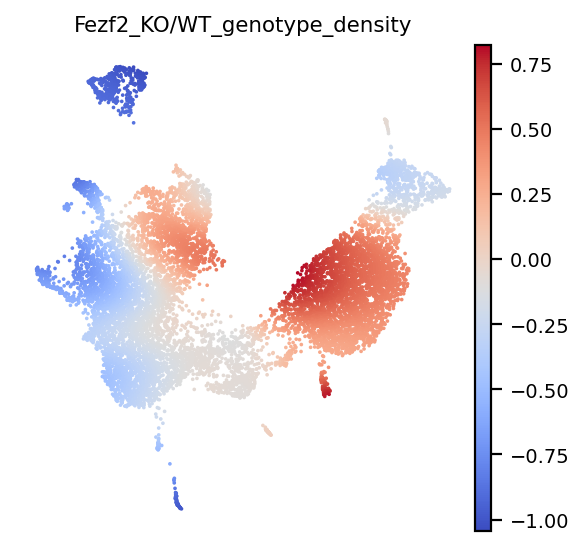

In [14]:
sc.settings.figdir = "/mnt/f/M-cells/analysis/Paper figs/Fig 3 (Fezf2 KO)/"
sc.pl.umap(
    adata,
    color="Fezf2_KO/WT_genotype_density",
    cmap="coolwarm",
    save="_3B_differential_density.pdf",
)